# Logistic Regression for Board Game Success

After the initial EDA for my Capstone 1 project, I have cleaned up a dataset containing around 30K board games (20K if you eliminate all NaNs in certain features), and can now attempt to model if a board game will be successful. To do this, I will be splitting the target variable (Rating) into a binary classification of successful (1) and unsuccessful (0). Then, I can utilize sklearn's functionality to run a logistic regression to predict which category a given board game should fall under.

## An initial cutoff point for success

The first question I need to answer is where the correct cutoff point for success should be. That is to say, at what rating (or higher) is a board game considered successful? Normally, this would be an answer for a client to answer -- do board games of a given rating tend to make them more money than those of lower rating? Are they aiming for a given rating and wish to build with that rating in mind? 

Given that there is no specific client here, I'll have to choose based on the EDA I carried out in the previous notebook. I found that if you look at all the ratings in the dataset, the 75th percentile lies at approximately 6.05, not far from the median at 5.69. I like the idea of having an even number being a cutoff point, but let's load in the data and see where 6 and 7 lies in the distribution of ratings:

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

with open('BGG_NoNaN_DF.pkl', 'rb') as f:
    noNaN_DF = pickle.load(f)

# For now, I'm going to work with the fully cleaned data (noNaN_DF), so I can use all of
# the features.
noNaN_DF.describe()

,ID Num,Rating,Standard Dev,Weight,User Number,Min Playtime,Max Playtime,Year Published,Min Players,Max Players
count,17574.000000,17574.000000,17574.000000,17574.000000,17574.000000,17574.000000,17574.000000,17574.000000,17574.000000,17574.000000
mean,79099.993229,5.742222,1.477130,2.154179,701.678787,76.947081,89.474735,2004.537555,2.028224,4.719813
std,74571.689197,0.401148,0.269741,0.811121,2665.869982,495.422482,525.694505,12.970024,0.638402,2.348298
min,1.000000,3.729410,0.192413,1.000000,23.000000,1.000000,1.000000,1903.000000,1.000000,1.000000
25%,8481.750000,5.523512,1.290072,1.500000,58.000000,30.000000,30.000000,2000.000000,2.000000,4.000000
50%,42191.500000,5.583410,1.440445,2.000000,124.000000,45.000000,60.000000,2009.000000,2.000000,4.000000
75%,149274.750000,5.781950,1.618910,2.692300,378.000000,90.000000,90.000000,2014.000000,2.000000,6.000000
max,249414.000000,8.622630,3.990480,5.000000,76405.000000,60000.000000,60000.000000,2019.000000,9.000000,20.000000


In [2]:
noNaN_DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17574 entries, Die Macher to Backyard Builders Treehouse
Data columns (total 10 columns):
ID Num            17574 non-null int64
Rating            17574 non-null float64
Standard Dev      17574 non-null float64
Weight            17574 non-null float64
User Number       17574 non-null float64
Min Playtime      17574 non-null float64
Max Playtime      17574 non-null float64
Year Published    17574 non-null float64
Min Players       17574 non-null float64
Max Players       17574 non-null float64
dtypes: float64(9), int64(1)

In [3]:
noNaN_DF.quantile([0.75, 0.8, 0.85, 0.9])

,ID Num,Rating,Standard Dev,Weight,User Number,Min Playtime,Max Playtime,Year Published,Min Players,Max Players
0.75,149274.75,5.781950,1.618910,2.6923,378.0,90,90,2014,2,6
0.80,161435.20,5.880450,1.668314,2.8750,528.4,90,120,2014,2,6
0.85,173075.10,6.032113,1.728849,3.0000,772.0,120,120,2015,2,6
0.90,186688.40,6.262704,1.811957,3.2500,1276.7,150,180,2016,3,8


It looks like when the excess rows were cleaned out to remove the NaNs, it shrunk in the distribution to be even more closely peaked at the median, with the 75th percentile becoming just 5.77, and if I select a cutoff at 6, it will be around the 85th percentile, which seems too high for a success metric. It seems that I will have to choose a non-round number for the cutoff, which is fine. I think the 80th percentile is a good cutoff to try, which would be for many a conservative estimate of success (not everyone might consider a 5.87 out of 10 rating to be a successful product), but given the spread, this might be good enough for a first attempt.

Now that we have a cutoff, I can alter the ratings to become a binary classification as mentioned earlier. Now, more specifically, any rating above a 5.87 will be a success (1) and below will be not be a success (0).

In [4]:
ratings = noNaN_DF['Rating']
ratings80 = np.percentile(noNaN_DF['Rating'], 80)
target = ratings.apply(lambda x: x >= ratings80)
print(target)

Die Macher             True
Dragonmaster          False
Samouraï               True
Tal der Könige        False
Acquire                True
Mare Mediterraneum    False
Castle City            True
Lords of Creation     False
El Caballero           True
Elfenland              True
Babszüret              True
Ra                     True
Catan                  True
Basari                 True
Contatos Cósmicos      True
...
Race to the New Found Land                                   False
Ganz schön clever                                            False
Escape the Dark Castle: Cult of the Death Knight             False
Dobbelland                                                   False
Goblin Grapple                                               False
Clank!: The Mummy's Curse                                    False
Coimbra                                                      False
Kwiatki                                                      False
Warhammer Underworlds: Shadespire – Nuée

In [5]:
target.quantile([0.75, 0.80])

0.75    0
0.80    1
dtype: float64

Now that I have the cutoff sucessfully implemented into a Pandas Series, and I have the ratings saved as its own series, I need to drop the target from the dataframe containing all of the features. At that stage, I'll have what I need for my logistic regression: a target series and a feature dataframe.

In [6]:
# I will keep the Standard Deviation in the rating as a potential feature for now.
features = noNaN_DF.drop(['Rating', 'ID Num', 'User Number', 'Standard Dev'], axis=1)
features.shape

(17574, 6)

## Logistic Regression using sklearn

Now that we have a target and some features, it's time to use sklearn to create a logistic regression model. I don't know whether or not I have sparse features, so I will start by using an L2 regularization model for computational efficiency, and will use cross-validation grid searching to determine the best hyperparameter "C" used for regularization strength.

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix

# First, we split the data into a training and test set, using a 70-30 split:
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, 
                                                    test_size=0.3, random_state=42)

# Now, we can perform the grid search for the logistic regression model hyperparameter:
logreg = LogisticRegression(random_state=42)    # L2 regularization is the default mode
C_vals = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
clf_grid = GridSearchCV(logreg, {'C': C_vals}, cv=5, scoring='accuracy')
clf_grid.fit(X_train, y_train)
print(clf_grid.best_params_, clf_grid.best_score_)
print('\n')
print(accuracy_score(clf_grid.predict(X_test), y_test))
print('\n')
print(confusion_matrix(clf_grid.predict(X_test), y_test))

{'C': 0.0001} 0.7996910820258516


0.8001137872179025


[[4219 1054]
 [   0    0]]


In [8]:
# The accuracy looks pretty good, let's look at the classification report:
y_predict_train = clf_grid.predict(X_train)
y_predict_test = clf_grid.predict(X_test)

print("[Training Classification Report:]")
print(classification_report(y_train, y_predict_train))

print("[Test Classification Report:]")
print(classification_report(y_test, y_predict_test))

[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.80      1.00      0.89      9839
       True       0.00      0.00      0.00      2462

avg / total       0.64      0.80      0.71     12301

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.80      1.00      0.89      4219
       True       0.00      0.00      0.00      1054

avg / total       0.64      0.80      0.71      5273



/Users/danielfeldman/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


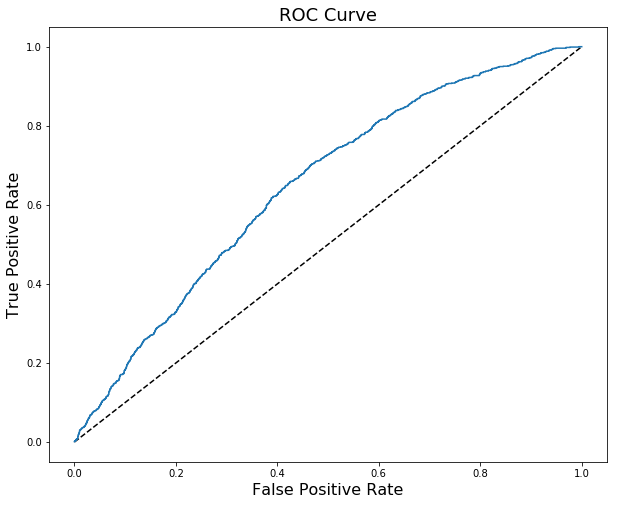



AUC: 0.647579756887272


In [9]:
# Plot an ROC curve for the model:
y_pred_prob = clf_grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.plot([0, 1], [0, 1], 'k--')
_ = axes.plot(fpr, tpr)
_ = axes.set_xlabel('False Positive Rate', fontsize=16)
_ = axes.set_ylabel('True Positive Rate', fontsize=16)
_ = plt.title('ROC Curve', fontsize=18)
plt.show()

# Compute and print AUC score
print('\n')
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

In this model, I found that the logistic regression has some interesting properties. In terms of straight accuracy, it does a very good job, yielding a 92% accuracy score on the test data. However, it's also important to dig a bit deeper, which is done via the classification report, yielding the precision, recall, and F1-score for the successful (True class) and not successful (False class). In our model, we find that the recall for the negative class is 0.99, which makes the specificity of the model is very high. As such, it is unlikely for an unsucessful board game to have success attributed to it. However, the recall for the positive class, while not terrible, is a lot lower at 0.66, which means that the sensitivity of the model is moderate. In other words, there is a somewhat better than 50% chance of having a successful board game predicted to be a dud.

For a board game seller, this model could be considered a conservative model for deciding if a board game is worth selling, as it's unlikely to suggest bad board games to sell, but it would miss a fair amount of good ones.

Let's see what happens if we use L1 regularization instead of L2 for our logistic regression:

{'C': 0.0001} 0.7997723762295749


0.8001137872179025


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.80      1.00      0.89      9839
       True       0.00      0.00      0.00      2462

avg / total       0.64      0.80      0.71     12301

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.80      1.00      0.89      4219
       True       0.00      0.00      0.00      1054

avg / total       0.64      0.80      0.71      5273



/Users/danielfeldman/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


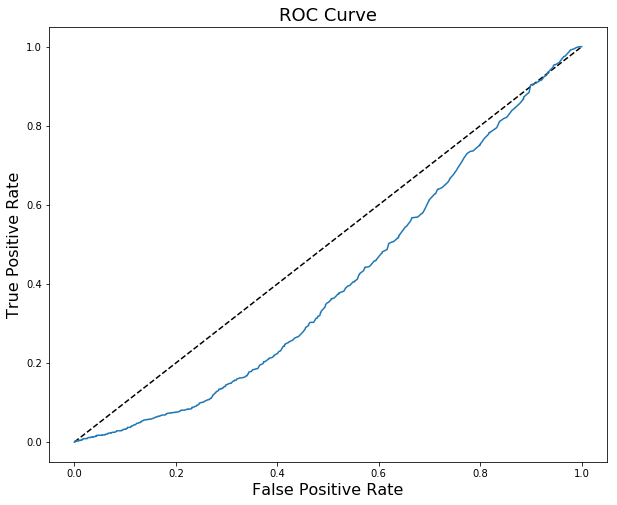



AUC: 0.4049167878392363


In [10]:
# Initialize and use Grid search with L1 regularization:
logreg = LogisticRegression(penalty='l1', random_state=42)
clf_grid = GridSearchCV(logreg, {'C': C_vals}, cv=5, scoring='accuracy')
# Fit using training data:
clf_grid.fit(X_train, y_train)

# Predictions:
y_predict_train = clf_grid.predict(X_train)
y_predict_test = clf_grid.predict(X_test)

# Results for Accuracy:
print(clf_grid.best_params_, clf_grid.best_score_)
print('\n')
#print(clf_grid.get_params)
#print('\n')
print(accuracy_score(y_predict_test, y_test))
print('\n')

# Results for Classification Report:
print("[Training Classification Report:]")
print(classification_report(y_train, y_predict_train))

print("[Test Classification Report:]")
print(classification_report(y_test, y_predict_test))

# Plot an ROC curve for the model:
y_pred_prob = clf_grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.plot([0, 1], [0, 1], 'k--')
_ = axes.plot(fpr, tpr)
_ = axes.set_xlabel('False Positive Rate', fontsize=16)
_ = axes.set_ylabel('True Positive Rate', fontsize=16)
_ = plt.title('ROC Curve', fontsize=18)
plt.show()

# Compute and print AUC score
print('\n')
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

The results of this modeling procedure appears to be the same as the previous, though it is less computationally efficient.

I'm going to see if the results are better if I use a more conservative cutoff, and if I use a less conservative cutoff (75% and 85%):

{'C': 0.0001} 0.7481505568652955


0.754029963967381
[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.75      1.00      0.86      9205
       True       0.50      0.00      0.00      3096

avg / total       0.69      0.75      0.64     12301

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.75      1.00      0.86      3975
       True       1.00      0.00      0.00      1298

avg / total       0.81      0.75      0.65      5273



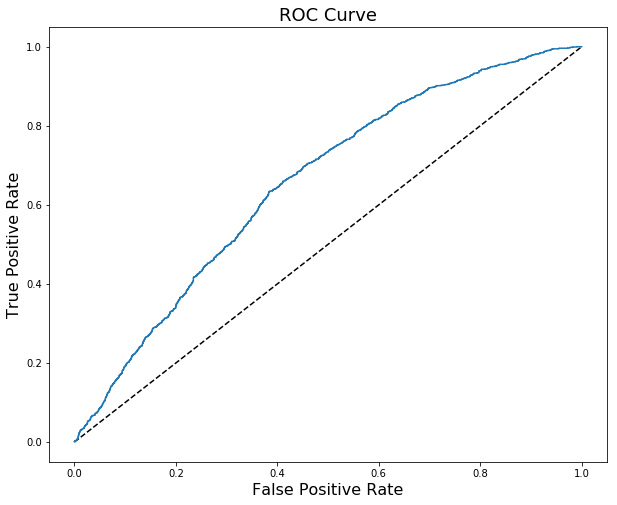



AUC: 0.6551462821370082


In [11]:
# First, let's do the 75% cutoff instead of 80%:
ratings = noNaN_DF['Rating']
target75 = ratings.apply(lambda x: x >= np.percentile(noNaN_DF['Rating'], 75))

# First, we split the data into a training and test set, using a 70-30 split:
X_train75, X_test75, y_train75, y_test75 = train_test_split(features.values, target75.values, 
                                                    test_size=0.3, random_state=42)

# Now, we can perform the grid search for the logistic regression model hyperparameter:
logreg = LogisticRegression(random_state=42)    # L2 regularlization is the default mode
clf_grid75 = GridSearchCV(logreg, {'C': C_vals}, cv=5, scoring='accuracy')
clf_grid75.fit(X_train75, y_train75)
y_predict_test75 = clf_grid75.predict(X_test75)
print(clf_grid75.best_params_, clf_grid75.best_score_)
print('\n')
print(accuracy_score(y_predict_test75, y_test75))

y_predict_train75 = clf_grid75.predict(X_train75)

print("[Training Classification Report:]")
print(classification_report(y_train75, y_predict_train75))

print("[Test Classification Report:]")
print(classification_report(y_test75, y_predict_test75))

# Plot an ROC curve for the model:
y_pred_prob75 = clf_grid75.predict_proba(X_test75)[:,1]
fpr75, tpr75, thresholds75 = roc_curve(y_test75, y_pred_prob75)

# Plot:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.plot([0, 1], [0, 1], 'k--')
_ = axes.plot(fpr75, tpr75)
_ = axes.set_xlabel('False Positive Rate', fontsize=16)
_ = axes.set_ylabel('True Positive Rate', fontsize=16)
_ = plt.title('ROC Curve', fontsize=18)
plt.show()

# Compute and print AUC score
print('\n')
print("AUC: {}".format(roc_auc_score(y_test75, y_pred_prob75)))

{'C': 0.0001} 0.8494431347044956


0.8509387445476958
[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.85      1.00      0.92     10451
       True       0.00      0.00      0.00      1850

avg / total       0.72      0.85      0.78     12301

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.85      1.00      0.92      4487
       True       0.00      0.00      0.00       786

avg / total       0.72      0.85      0.78      5273



/Users/danielfeldman/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


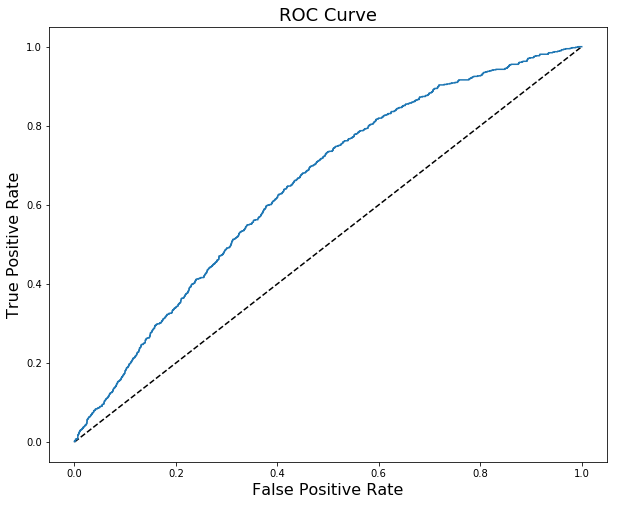



AUC: 0.6478239936576743


In [12]:
# Now, let's do the 85% cutoff instead of 80%:
ratings = noNaN_DF['Rating']
target85 = ratings.apply(lambda x: x >= np.percentile(noNaN_DF['Rating'], 85))

# First, we split the data into a training and test set, using a 70-30 split:
X_train85, X_test85, y_train85, y_test85 = train_test_split(features.values, target85.values, 
                                                    test_size=0.3, random_state=42)

# Now, we can perform the grid search for the logistic regression model hyperparameter:
logreg = LogisticRegression(random_state=42)    # L2 regularlization is the default mode
clf_grid85 = GridSearchCV(logreg, {'C': C_vals}, cv=5, scoring='accuracy')
clf_grid85.fit(X_train85, y_train85)
y_predict_test85 = clf_grid85.predict(X_test85)
print(clf_grid85.best_params_, clf_grid85.best_score_)
print('\n')
print(accuracy_score(y_predict_test85, y_test85))

y_predict_train85 = clf_grid85.predict(X_train85)

print("[Training Classification Report:]")
print(classification_report(y_train85, y_predict_train85))

print("[Test Classification Report:]")
print(classification_report(y_test85, y_predict_test85))

# Plot an ROC curve for the model:
y_pred_prob85 = clf_grid85.predict_proba(X_test85)[:,1]
fpr85, tpr85, thresholds85 = roc_curve(y_test85, y_pred_prob85)

# Plot:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.plot([0, 1], [0, 1], 'k--')
_ = axes.plot(fpr85, tpr85)
_ = axes.set_xlabel('False Positive Rate', fontsize=16)
_ = axes.set_ylabel('True Positive Rate', fontsize=16)
_ = plt.title('ROC Curve', fontsize=18)
plt.show()

# Compute and print AUC score
print('\n')
print("AUC: {}".format(roc_auc_score(y_test85, y_pred_prob85)))

It looks like having a more conservative cutoff of 75% made the model slightly worse, while the less conservative cutoff of 85% slightly improved the model, but only with slight gains in accuracy and precision, and did not help with the poor recall.

In [13]:
logreg = LogisticRegression(C=1.0, random_state=42)
logreg.fit(X_train, y_train)
print(logreg.coef_)
print('\n')
print(accuracy_score(clf_grid.predict(X_test), y_test))
print('\n')
print(confusion_matrix(clf_grid.predict(X_test), y_test))

[[ 8.16342851e-01 -2.54470301e-03 -8.13821219e-05 -1.61890599e-03
  -2.18303963e-02  5.39571066e-02]]


0.8001137872179025


[[4219 1054]
 [   0    0]]


In [14]:
for i in range(len(features.columns)):
    print('Coefficient for {}: {}\n'.format(features.columns[i], logreg.coef_[0][i]))

Coefficient for Weight: 0.8163428507046117

Coefficient for Min Playtime: -0.002544703014108723

Coefficient for Max Playtime: -8.138212186541429e-05

Coefficient for Year Published: -0.0016189059938453258

Coefficient for Min Players: -0.021830396307040357

Coefficient for Max Players: 0.05395710663829593



In [15]:
features_no_users = features
print(features_no_users.shape)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(features_no_users.values, target.values, 
                                                    test_size=0.3, random_state=42)
logreg_new = LogisticRegression(C=0.01, random_state=42)
logreg_new.fit(X_train_new, y_train_new)
y_predict_train_new = logreg_new.predict(X_train_new)
y_predict_test_new = logreg_new.predict(X_test_new)
print(accuracy_score(y_predict_test_new, y_test_new))
print('\n')
print(confusion_matrix(y_predict_test_new, y_test_new))
print('\n')
print("[Training Classification Report:]")
print(classification_report(y_train_new, y_predict_train_new))

print("[Test Classification Report:]")
print(classification_report(y_test_new, y_predict_test_new))
for i in range(len(features_no_users.columns)):
    print('Coefficient for {}: {}\n'.format(features_no_users.columns[i], logreg_new.coef_[0][i]))

(17574, 6)
0.7982173335861938


[[4205 1050]
 [  14    4]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.80      1.00      0.89      9839
       True       0.04      0.00      0.00      2462

avg / total       0.65      0.80      0.71     12301

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.80      1.00      0.89      4219
       True       0.22      0.00      0.01      1054

avg / total       0.68      0.80      0.71      5273

Coefficient for Weight: 0.6315097663181017

Coefficient for Min Playtime: -0.0015557685487209718

Coefficient for Max Playtime: -1.5124047351512637e-05

Coefficient for Year Published: -0.001414439323267226

Coefficient for Min Players: -0.047561237418037576

Coefficient for Max Players: 0.05220396134032294



## Using SMOTE to help with the imbalance in our dataset

A major issue we have with our dataset is that it is imbalanced -- because we consider the top 80% of games to be members of the successful class, there is a 4:1 ratio between the 0 class and 1 class respectively. This will introduce problems with our classifier. One way to address this is to generate synthetic entries of the minority class, in this case the successful (1) board game class. To do this, we will use the SMOTE method, coded up in Python in the __[imblearn](http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/over-sampling/plot_smote.html#sphx-glr-auto-examples-over-sampling-plot-smote-py)__ module.

**To start, we will use SMOTE first, then do a train-test split:**

In [16]:
from imblearn.over_sampling import SMOTE

# Establish data set features and target:
X_before = features_no_users.values
y_before = target.values
print(X_before.shape, y_before.shape)

# There are 4 different SMOTE algorithms, so let's try each one:
kinds = ['regular', 'borderline1', 'borderline2', 'svm']
for k in kinds:
    
    # Use SMOTE to generate synthetic samples of the minority class:
    sm = SMOTE(kind=k, random_state=42)  # Without an input ratio, will generate until equal representation
    X_after, y_after = sm.fit_sample(X_before, y_before)
    print('SMOTE Algorithm: {}'.format(k))
    print('--------------------------------------')

    # Do a train-test split of 70-30 on the new dataset:
    X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_after, y_after, 
                                                    test_size=0.3, random_state=42)
    
    # Do a grid search for the best regularization parameter:
    logreg_grid = LogisticRegression(random_state=42)
    clf_res = GridSearchCV(logreg_grid, {'C': C_vals}, cv=5, scoring='accuracy')
    clf_res.fit(X_train_res, y_train_res)
    print(clf_res.best_params_, clf_res.best_score_)
    print('\n')
    
    # Retrain the logistic regression and make predictions:
    logreg_resample = LogisticRegression(C=clf_res.best_params_['C'], random_state=42)
    logreg_resample.fit(X_train_res, y_train_res)
    y_predict_train_res = logreg_resample.predict(X_train_res)
    y_predict_test_res = logreg_resample.predict(X_test_res)
    
    # Figure out the coefficients and summary statistics:
    for i in range(len(features_no_users.columns)):
        print('Coefficient for {}: {}\n'.format(features_no_users.columns[i], logreg_resample.coef_[0][i]))
    
    accuracy = accuracy_score(y_predict_test_res, y_test_res)
    print('Accuracy score: {}\n'.format(accuracy))
    print(confusion_matrix(y_predict_test_res, y_test_res))
    print('\n')
    print("[Training Classification Report:]")
    print(classification_report(y_train_res, y_predict_train_res))
    
    print("[Test Classification Report:]")
    print(classification_report(y_test_res, y_predict_test_res))

(17574, 6) (17574,)
SMOTE Algorithm: regular
--------------------------------------
{'C': 100.0} 0.6512880443066917


Coefficient for Weight: 0.8551542036265849

Coefficient for Min Playtime: -0.0013807267657551746

Coefficient for Max Playtime: -2.850371986724135e-05

Coefficient for Year Published: 0.027692820871854134

Coefficient for Min Players: 0.05470788883553962

Coefficient for Max Players: 0.051069945302343475

Accuracy score: 0.6602252519264967

[[2741 1364]
 [1502 2828]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.65      0.64      0.65      9815
       True       0.65      0.66      0.66      9866

avg / total       0.65      0.65      0.65     19681

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.67      0.65      0.66      4243
       True       0.65      0.67      0.66      4192

avg / total       0.66      0.66      0.66      8435

SMOTE Algorithm:

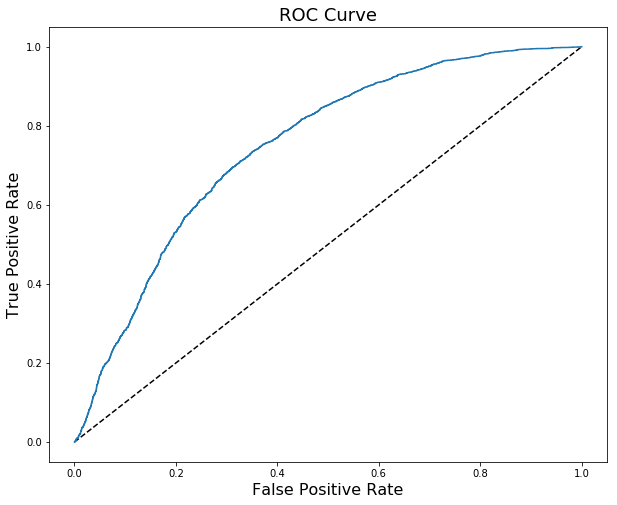



AUC: 0.748149286746199


In [17]:
# Plot an ROC curve for the model:
y_pred_prob_res = logreg_resample.predict_proba(X_test_res)[:,1]
fpr_res, tpr_res, thresholds_res = roc_curve(y_test_res, y_pred_prob_res)

# Plot:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.plot([0, 1], [0, 1], 'k--')
_ = axes.plot(fpr_res, tpr_res)
_ = axes.set_xlabel('False Positive Rate', fontsize=16)
_ = axes.set_ylabel('True Positive Rate', fontsize=16)
_ = plt.title('ROC Curve', fontsize=18)
plt.show()

# Compute and print AUC score
print('\n')
print("AUC: {}".format(roc_auc_score(y_test_res, y_pred_prob_res)))

**Now, try separating an original test set, then SMOTE on the whole thing, then delete duplicates of the test set in the resampled dataset:**

In [18]:
# Need a function that can identify where one array is located in another:
def array_delete(full_arr, subset):
    """
    Will take the subset and delete *all* duplicate entries from 
    the full array supplied.
    
    """
    index_list = []
    bool_list = np.isin(full_arr, subset)
    for index, line in enumerate(bool_list):
        if line.all():
            index_list.append(index)
    new_arr = np.delete(full_arr, index_list, axis=0)
    return new_arr, index_list

# Do a train-test split now to extract a test set on the original dataset
_Xtrain, X_test_before, _ytrain, y_test_before = train_test_split(X_before, y_before, 
                                                    test_size=0.3, random_state=42)

kinds = ['regular', 'borderline1', 'borderline2', 'svm']
for k in kinds:
    
    # Use SMOTE to generate synthetic samples of the minority class:
    sm = SMOTE(kind=k, random_state=42)  # Without an input ratio, will generate until equal representation
    X_after, y_after = sm.fit_sample(X_before, y_before)
    print('SMOTE Algorithm: {}'.format(k))
    print('--------------------------------------')

    # Remove the original test set from new train set:
    X_train_res, index_list = array_delete(X_after, X_test_before)
    y_train_res = np.delete(y_after, index_list, axis=0)
    print('Shapes of X_after, X_train_res, and X_test_before, for testing purposes:')
    print(X_after.shape, X_train_res.shape, X_test_before.shape)
    print('\n')
    
    # Do a grid search for the best regularization parameter:
    logreg_grid = LogisticRegression(random_state=42)
    clf_res = GridSearchCV(logreg_grid, {'C': C_vals}, cv=5, scoring='accuracy')
    clf_res.fit(X_train_res, y_train_res)
    print(clf_res.best_params_, clf_res.best_score_)
    print('\n')
    
    # Retrain the logistic regression and make predictions:
    logreg_resample = LogisticRegression(C=clf_res.best_params_['C'], random_state=42)
    logreg_resample.fit(X_train_res, y_train_res)
    y_predict_train_res = logreg_resample.predict(X_train_res)
    y_predict_test_res = logreg_resample.predict(X_test_before)
    
    # Figure out the coefficients and summary statistics:
    for i in range(len(features_no_users.columns)):
        print('Coefficient for {}: {}\n'.format(features_no_users.columns[i], logreg_resample.coef_[0][i]))
    
    accuracy = accuracy_score(y_predict_test_res, y_test_before)
    print('Accuracy score: {}\n'.format(accuracy))
    print(confusion_matrix(y_predict_test_res, y_test_before))
    print('\n')
    print("[Training Classification Report:]")
    print(classification_report(y_train_res, y_predict_train_res))
    
    print("[Test Classification Report:]")
    print(classification_report(y_test_before, y_predict_test_res))

SMOTE Algorithm: regular
--------------------------------------
Shapes of X_after, X_train_res, and X_test_before, for testing purposes:
(28116, 6) (13159, 6) (5273, 6)


{'C': 0.001} 0.9180788813739645


Coefficient for Weight: 0.17747751975517276

Coefficient for Min Playtime: -0.0005145339403944589

Coefficient for Max Playtime: -0.00026554562218811657

Coefficient for Year Published: 0.001080696184547403

Coefficient for Min Players: -0.04718424587197353

Coefficient for Max Players: -0.0012505582738416567

Accuracy score: 0.2004551488716101

[[   3    0]
 [4216 1054]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.38      0.00      0.01      1073
       True       0.92      1.00      0.96     12086

avg / total       0.87      0.92      0.88     13159

[Test Classification Report:]
             precision    recall  f1-score   support

      False       1.00      0.00      0.00      4219
       True       0.20      1.00

/Users/danielfeldman/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SMOTE Algorithm: svm
--------------------------------------
Shapes of X_after, X_train_res, and X_test_before, for testing purposes:
(28116, 6) (13176, 6) (5273, 6)


{'C': 0.0001} 0.9182604735883424


Coefficient for Weight: 0.036645580962450096

Coefficient for Min Playtime: -0.0006064724847207423

Coefficient for Max Playtime: -6.91580028945967e-05

Coefficient for Year Published: 0.001222072415883779

Coefficient for Min Players: -0.008812981292939035

Coefficient for Max Players: -0.00890138718117734

Accuracy score: 0.2004551488716101

[[   3    0]
 [4216 1054]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.29      0.00      0.00      1073
       True       0.92      1.00      0.96     12103

avg / total       0.87      0.92      0.88     13176

[Test Classification Report:]
             precision    recall  f1-score   support

      False       1.00      0.00      0.00      4219
       True       0.20      1.00     

**Lastly, we will train-test split on the original dataset, and use SMOTE on the train data only:**

In [19]:
from imblearn.over_sampling import SMOTE

# Establish data set features and target:
X_before = features_no_users.values
y_before = target.values
print(X_before.shape, y_before.shape)
    
# Do a train-test split of 70-30 on the new dataset:
X_train_before, X_test_res, y_train_before, y_test_res = train_test_split(X_before, y_before, 
                                                test_size=0.3, random_state=42)
# There are 4 different SMOTE algorithms, so let's try each one:
kinds = ['regular', 'borderline1', 'borderline2', 'svm']
for k in kinds:
    
    # Use SMOTE to generate synthetic samples of the minority class:
    sm = SMOTE(kind=k, random_state=42)  # Without an input ratio, will generate until equal representation
    X_train_res, y_train_res = sm.fit_sample(X_train_before, y_train_before)
    print('SMOTE Algorithm: {}'.format(k))
    print('--------------------------------------')
    
    # Do a grid search for the best regularization parameter:
    logreg_grid = LogisticRegression(random_state=42)
    clf_res = GridSearchCV(logreg_grid, {'C': C_vals}, cv=5, scoring='accuracy')
    clf_res.fit(X_train_res, y_train_res)
    print(clf_res.best_params_, clf_res.best_score_)
    print('\n')
    
    # Retrain the logistic regression and make predictions:
    logreg_resample = LogisticRegression(C=clf_res.best_params_['C'], random_state=42)
    logreg_resample.fit(X_train_res, y_train_res)
    y_predict_train_res = logreg_resample.predict(X_train_res)
    y_predict_test_res = logreg_resample.predict(X_test_res)
    
    # Figure out the coefficients and summary statistics:
    for i in range(len(features_no_users.columns)):
        print('Coefficient for {}: {}\n'.format(features_no_users.columns[i], logreg_resample.coef_[0][i]))
    
    accuracy = accuracy_score(y_predict_test_res, y_test_res)
    print('Accuracy score: {}\n'.format(accuracy))
    print(confusion_matrix(y_predict_test_res, y_test_res))
    print('\n')
    print("[Training Classification Report:]")
    print(classification_report(y_train_res, y_predict_train_res))
    
    print("[Test Classification Report:]")
    print(classification_report(y_test_res, y_predict_test_res))

(17574, 6) (17574,)
SMOTE Algorithm: regular
--------------------------------------
{'C': 100.0} 0.6552495172273605


Coefficient for Weight: 0.8487283375945294

Coefficient for Min Playtime: -0.0008302738035876088

Coefficient for Max Playtime: -6.662321128725815e-05

Coefficient for Year Published: 0.03256518998156665

Coefficient for Min Players: 0.08628806541000889

Coefficient for Max Players: 0.04242814991072839

Accuracy score: 0.6419495543333965

[[2694  363]
 [1525  691]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.66      0.64      0.65      9839
       True       0.65      0.67      0.66      9839

avg / total       0.65      0.65      0.65     19678

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.88      0.64      0.74      4219
       True       0.31      0.66      0.42      1054

avg / total       0.77      0.64      0.68      5273

SMOTE Algorithm: b

So, it would appear the best results I got were from using the "svm" SMOTE algorithm, and from using it before the train-test-split. This ended with a model accuracy of about 74%, and an f1-score of 74% as well. But is this the best way to deal with the imbalance in my dataset?

## Under-sampling the dataset (Small ensemble classifier)

Another way of addressing an imbalanced dataset problem is to under-sample the majority class. Given the amount of data in my dataset (20000 entries), achieving a balance between the successful and unsuccessful board games would require me to trim my dataset way down. I don't want to delete my data completely, so instead I will create an ensemble classifier by splitting up the majority classes into groups and then taking the majority vote of each one.

In [21]:
# First, let's separate out the different classes in the dataset:
target.name = 'Target'
#noNaN_DF = pd.concat([noNaN_DF, target], axis=1)
trues = noNaN_DF.loc[noNaN_DF.Target==True]
falses = noNaN_DF.loc[noNaN_DF.Target==False]
trues_y = trues['Target']
trues_X = trues.drop(['Rating', 'Target', 'ID Num'], axis=1)
falses_y = falses['Target']
falses_X = falses.drop(['Rating', 'Target', 'ID Num'], axis=1)

# Do a 80-20 train-test-split on trues and falses to build the test set:
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(trues_X.values, 
                                                    trues_y.values, test_size=0.2, random_state=42)
X_train_false, X_test_false, y_train_false, y_test_false = train_test_split(falses_X.values, 
                                                    falses_y.values, test_size=0.2, random_state=42)
X_test_folds = np.concatenate((X_test_true, X_test_false))
y_test_folds = np.concatenate((y_test_true, y_test_false))
# Because of the 80-20 split, eventually each of the classifiers will have a test set about 35% of the
# size of the test+train dataset for that classifier (since each classifier shares the same test set).

# Separate the majority class into different folds:
false_split_len = len(X_train_false) // 3   # 4257 entries per fold
X_train_fold1 = X_train_false[0:false_split_len]
X_train_fold2 = X_train_false[false_split_len:(false_split_len*2)]
X_train_fold3 = X_train_false[(false_split_len*2):-2] # Must take out 2 to be even
y_train_fold = y_train_false[0:false_split_len]   # All y folds are identical (Falses)

# Combine into three separate training datasets, one per majority class fold:
# Note: each fold has a total of 7483 entries, 4257 False entries, 3226 True entries
features_fold1 = np.concatenate((X_train_fold1, X_train_true))
features_fold2 = np.concatenate((X_train_fold2, X_train_true))
features_fold3 = np.concatenate((X_train_fold3, X_train_true))
target_fold = np.concatenate((y_train_fold, y_train_true))  # All targets are identical

# Train 3 different logistic regression models, one per fold:
logreg_1 = LogisticRegression(random_state=42)
clf_1 = GridSearchCV(logreg_1, {'C': C_vals}, cv=5, scoring='accuracy')
clf_1.fit(features_fold1, target_fold)
logreg_2 = LogisticRegression(random_state=42)
clf_2 = GridSearchCV(logreg_2, {'C': C_vals}, cv=5, scoring='accuracy')
clf_2.fit(features_fold2, target_fold)
logreg_3 = LogisticRegression(random_state=42)
clf_3 = GridSearchCV(logreg_3, {'C': C_vals}, cv=5, scoring='accuracy')
clf_3.fit(features_fold3, target_fold)

# Predict on each one, using the test set created earlier (just to see):
fold1_pred = clf_1.predict(X_test_folds)
fold2_pred = clf_2.predict(X_test_folds)
fold3_pred = clf_3.predict(X_test_folds)
print('Accuracy for fold 1: {}'.format(accuracy_score(fold1_pred, y_test_folds)))
print('Accuracy for fold 2: {}'.format(accuracy_score(fold2_pred, y_test_folds)))
print('Accuracy for fold 3: {}'.format(accuracy_score(fold3_pred, y_test_folds)))

# Use this as an ensemble, by getting the majority vote:
votes = np.array(fold1_pred, dtype=int) + np.array(fold2_pred, dtype=int) + np.array(fold3_pred, dtype=int)
ensemble_pred = np.zeros(len(votes), dtype=bool)
for ind, value in enumerate(votes):
    if value > 1:
        ensemble_pred[ind] = True

# Print out the various metrics for the ensemble:        
print('Accuracy for ensemble: {}\n'.format(accuracy_score(ensemble_pred, y_test_folds)))
print('Confusion Matrix: \n')
print(confusion_matrix(ensemble_pred, y_test_folds))
print('\n')
print("[Test Classification Report:]")
print(classification_report(y_test_folds, ensemble_pred))

Accuracy for fold 1: 0.926905574516496
Accuracy for fold 2: 0.9308873720136519
Accuracy for fold 3: 0.9314562002275313
Accuracy for ensemble: 0.9323094425483504

Confusion Matrix: 

[[2692  118]
 [ 120  586]]


[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.96      0.96      0.96      2812
       True       0.83      0.83      0.83       704

avg / total       0.93      0.93      0.93      3516



In [22]:
print(len(np.where(votes==0)[0]))
print(len(np.where(votes==1)[0]))
print(len(np.where(votes==2)[0]))
print(len(np.where(votes==3)[0]))

2719
91
26
680


Usually, for an Ensemble classifier, you have a much larger set of classifiers, and in this case, it can be accomplished by randomly sampling from my majority class so that I can create different samples for regression training. Then I can again implement a weighted majority vote based on the accuracy of any particular model. For reproducability, I would need to save the classifiers (and the weights) so they can be used again with new data.

In [23]:
# I can still use the test set I gathered in the previous ensemble alogrithm,
# named X_test_folds and y_test_folds.

# Now we will need to loop through the algorithm for creating a new training
# set and training the logistic regression model to save for later. Let's
# use a total of 1000 classifiers for our ensemble.

def accuracy_weighting(accuracy, vote):
    if vote:
        new_vote = accuracy
    else:
        new_vote = 1.0 - accuracy
    return new_vote

from sklearn.externals import joblib  # For pickling/unpickling models for saving
PKLPATH = 'pkl_files/'
models = []
votes = []

for j in range(1000):
    # Use train-test-split to grab a random 26% assortment of remaining training data:
    X_false_random, _1, y_false_random, _2 = train_test_split(X_train_false, 
                                                    y_train_false, test_size=0.74, random_state=j)
    X_train_random = np.concatenate((X_false_random, X_train_true)) # 3320 False, 3226 True
    y_train_random = np.concatenate((y_false_random, y_train_true))
    
    # Do a grid search to train the log regression model:
    logreg_rand = LogisticRegression(random_state=j)
    clf_rand = GridSearchCV(logreg_rand, {'C': C_vals}, cv=5, scoring='accuracy')
    clf_rand.fit(X_train_random, y_train_random)
    
    # Vote (predict) on the test set and then apply weight based on accuracy:
    prediction = clf_rand.predict(X_test_folds)
    vote = np.array(prediction, dtype=float) # Individual vote
    accuracy = accuracy_score(prediction, y_test_folds)
    vote_weighted = np.fromiter((accuracy_weighting(accuracy, v) for v in vote), float)
    
    # Save model, then place it and its vote inside the models and votes list for later:
    joblib.dump(clf_rand, '{}log_reg_rand{}.pkl'.format(PKLPATH, str(j)))
    models.append(joblib.load('{}log_reg_rand{}.pkl'.format(PKLPATH, str(j))))
    votes.append(vote_weighted)

In [24]:
# Now we have all of the models and votes collected, so we can create the ensemble vote:
ensemble_vote = np.sum(votes, axis=0)
ensemble_predict = np.zeros(len(ensemble_vote), dtype=bool)
for index, vote in enumerate(ensemble_vote):
    if vote >= 500.0:
        ensemble_predict[index] = True

# Finally, let's calculate the relevant metrics:
print('Accuracy for full ensemble: {}\n'.format(accuracy_score(ensemble_predict, y_test_folds)))
print('Confusion Matrix: \n')
print(confusion_matrix(ensemble_predict, y_test_folds))
print('\n')
print("[Test Classification Report:]")
print(classification_report(y_test_folds, ensemble_predict))

Accuracy for full ensemble: 0.9263367463026166

Confusion Matrix: 

[[2641   88]
 [ 171  616]]


[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.97      0.94      0.95      2812
       True       0.78      0.88      0.83       704

avg / total       0.93      0.93      0.93      3516



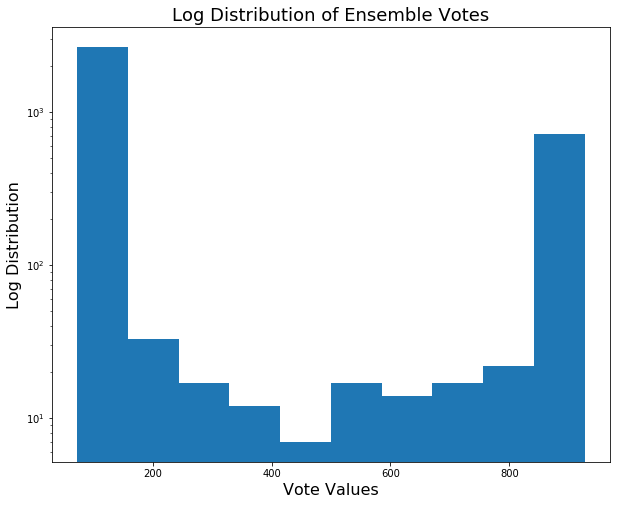

In [25]:
# Plot the distribution of ensemble votes:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.hist(ensemble_vote, bins=10)
_ = axes.set_xlabel('Vote Values', fontsize=16)
_ = axes.set_ylabel('Log Distribution', fontsize=16)
_ = axes.set_yscale('log')
_ = plt.title('Log Distribution of Ensemble Votes', fontsize=18)
plt.show()

With a recall of 82% for the True class, this ensemble method is the best one for the logistic regression model. It's a bit less interpretable from an individual parameter standpoint, but the weights are likely not too different from the individual models seen previously in this notebook. 

In [26]:
print(len(X_false_random))

2923


In [27]:
falses_X.columns

Index(['Standard Dev', 'Weight', 'User Number', 'Min Playtime', 'Max Playtime', 'Year Published', 'Min Players', 'Max Players'], dtype='object')

In [28]:
def accuracy_weighting(accuracy, vote):
    if vote:
        new_vote = accuracy
    else:
        new_vote = 1.0 - accuracy
    return new_vote

from sklearn.externals import joblib  # For pickling/unpickling models for saving
PKLPATH = 'pkl_files/'

trues = noNaN_DF.loc[noNaN_DF.Target==True]
falses = noNaN_DF.loc[noNaN_DF.Target==False]
trues_y = trues['Target']
trues_X = trues.drop(['Rating', 'Target', 'ID Num', 'User Number', 'Standard Dev'], axis=1)
falses_y = falses['Target']
falses_X = falses.drop(['Rating', 'Target', 'ID Num', 'User Number', 'Standard Dev'], axis=1)

# Do a 80-20 train-test-split on trues and falses to build the test set:
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(trues_X.values, 
                                                    trues_y.values, test_size=0.2, random_state=42)
X_train_false, X_test_false, y_train_false, y_test_false = train_test_split(falses_X.values, 
                                                    falses_y.values, test_size=0.2, random_state=42)
X_test_folds = np.concatenate((X_test_true, X_test_false))
y_test_folds = np.concatenate((y_test_true, y_test_false))

models = []
votes = []

for j in range(1000):
    # Use train-test-split to grab a random 26% assortment of remaining training data:
    X_false_random, _1, y_false_random, _2 = train_test_split(X_train_false, 
                                                    y_train_false, test_size=0.74, random_state=j)
    X_train_random = np.concatenate((X_false_random, X_train_true)) # 3320 False, 3226 True
    y_train_random = np.concatenate((y_false_random, y_train_true))
    
    # Do a grid search to train the log regression model:
    logreg_rand = LogisticRegression(random_state=j)
    clf_rand = GridSearchCV(logreg_rand, {'C': C_vals}, cv=5, scoring='accuracy')
    clf_rand.fit(X_train_random, y_train_random)
    
    # Vote (predict) on the test set and then apply weight based on accuracy:
    prediction = clf_rand.predict(X_test_folds)
    vote = np.array(prediction, dtype=float) # Individual vote
    accuracy = accuracy_score(prediction, y_test_folds)
    vote_weighted = np.fromiter((accuracy_weighting(accuracy, v) for v in vote), float)
    
    # Save model, then place it and its vote inside the models and votes list for later:
    joblib.dump(clf_rand, '{}log_reg_rand_less{}.pkl'.format(PKLPATH, str(j)))
    models.append(joblib.load('{}log_reg_rand_less{}.pkl'.format(PKLPATH, str(j))))
    votes.append(vote_weighted)

# Now we have all of the models and votes collected, so we can create the ensemble vote:
ensemble_vote = np.sum(votes, axis=0)
ensemble_predict = np.zeros(len(ensemble_vote), dtype=bool)
for index, vote in enumerate(ensemble_vote):
    if vote >= 500.0:
        ensemble_predict[index] = True

# Finally, let's calculate the relevant metrics:
print('Accuracy for full ensemble: {}\n'.format(accuracy_score(ensemble_predict, y_test_folds)))
print('Confusion Matrix: \n')
print(confusion_matrix(ensemble_predict, y_test_folds))
print('\n')
print("[Test Classification Report:]")
print(classification_report(y_test_folds, ensemble_predict))

Accuracy for full ensemble: 0.6686575654152446

Confusion Matrix: 

[[1920  273]
 [ 892  431]]


[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.88      0.68      0.77      2812
       True       0.33      0.61      0.43       704

avg / total       0.77      0.67      0.70      3516



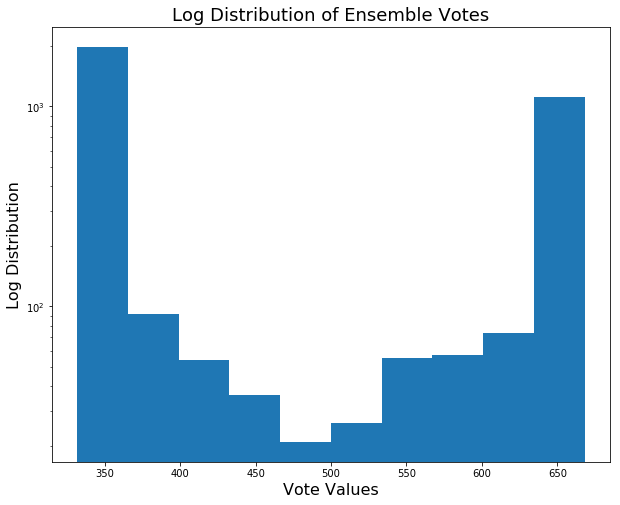

In [29]:
# Plot the distribution of ensemble votes:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.hist(ensemble_vote, bins=10)
_ = axes.set_xlabel('Vote Values', fontsize=16)
_ = axes.set_ylabel('Log Distribution', fontsize=16)
_ = axes.set_yscale('log')
_ = plt.title('Log Distribution of Ensemble Votes', fontsize=18)
plt.show()

## Redoing SMOTE with fewer features

No more Standard Deviation:

In [30]:
ratings = noNaN_DF['Rating']
target = ratings.apply(lambda x: x >= 5.84)
features = noNaN_DF.drop(['Standard Dev', 'ID Num', 'User Number', 'Rating', 'Target'], axis=1)
print(features.columns)

Index(['Weight', 'Min Playtime', 'Max Playtime', 'Year Published', 'Min Players', 'Max Players'], dtype='object')


In [31]:
# Establish data set features and target:
X_before = features.values
y_before = target.values
print(X_before.shape, y_before.shape)

# There are 4 different SMOTE algorithms, so let's try each one:
kinds = ['regular', 'borderline1', 'borderline2', 'svm']
for k in kinds:
    
    # Use SMOTE to generate synthetic samples of the minority class:
    sm = SMOTE(kind=k, random_state=42)  # Without an input ratio, will generate until equal representation
    X_after, y_after = sm.fit_sample(X_before, y_before)
    print('SMOTE Algorithm: {}'.format(k))
    print('--------------------------------------')

    # Do a train-test split of 70-30 on the new dataset:
    X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_after, y_after, 
                                                    test_size=0.3, random_state=42)
    
    # Do a grid search for the best regularization parameter:
    logreg_grid = LogisticRegression(random_state=42)
    clf_res = GridSearchCV(logreg_grid, {'C': C_vals}, cv=5, scoring='accuracy')
    clf_res.fit(X_train_res, y_train_res)
    print(clf_res.best_params_, clf_res.best_score_)
    print('\n')
    
    # Retrain the logistic regression and make predictions:
    logreg_resample = LogisticRegression(C=clf_res.best_params_['C'], random_state=42)
    logreg_resample.fit(X_train_res, y_train_res)
    y_predict_train_res = logreg_resample.predict(X_train_res)
    y_predict_test_res = logreg_resample.predict(X_test_res)
    
    # Figure out the coefficients and summary statistics:
    for i in range(len(features.columns)):
        print('Coefficient for {}: {}\n'.format(features.columns[i], logreg_resample.coef_[0][i]))
    
    accuracy = accuracy_score(y_predict_test_res, y_test_res)
    print('Accuracy score: {}\n'.format(accuracy))
    print(confusion_matrix(y_predict_test_res, y_test_res))
    print('\n')
    print("[Training Classification Report:]")
    print(classification_report(y_train_res, y_predict_train_res))
    
    print("[Test Classification Report:]")
    print(classification_report(y_test_res, y_predict_test_res))

(17574, 6) (17574,)
SMOTE Algorithm: regular
--------------------------------------
{'C': 100.0} 0.6533895657606997


Coefficient for Weight: 0.8588330876210754

Coefficient for Min Playtime: -0.0011299624868817604

Coefficient for Max Playtime: -4.006714703264093e-05

Coefficient for Year Published: 0.03130327761733393

Coefficient for Min Players: 0.03721344512742366

Coefficient for Max Players: 0.04265689347979345

Accuracy score: 0.6571914480077745

[[2700 1363]
 [1459 2710]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.66      0.64      0.65      9560
       True       0.65      0.67      0.66      9646

avg / total       0.65      0.65      0.65     19206

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.66      0.65      0.66      4159
       True       0.65      0.67      0.66      4073

avg / total       0.66      0.66      0.66      8232

SMOTE Algorithm: b

In [32]:
from imblearn.over_sampling import SMOTE

# Establish data set features and target:
X_before = features.values
y_before = target.values
print(X_before.shape, y_before.shape)
    
# Do a train-test split of 70-30 on the new dataset:
X_train_before, X_test_res, y_train_before, y_test_res = train_test_split(X_before, y_before, 
                                                test_size=0.3, random_state=42)
# There are 4 different SMOTE algorithms, so let's try each one:
kinds = ['regular', 'borderline1', 'borderline2', 'svm']
for k in kinds:
    
    # Use SMOTE to generate synthetic samples of the minority class:
    sm = SMOTE(kind=k, random_state=42)  # Without an input ratio, will generate until equal representation
    X_train_res, y_train_res = sm.fit_sample(X_train_before, y_train_before)
    print('SMOTE Algorithm: {}'.format(k))
    print('--------------------------------------')
    
    # Do a grid search for the best regularization parameter:
    logreg_grid = LogisticRegression(random_state=42)
    clf_res = GridSearchCV(logreg_grid, {'C': C_vals}, cv=5, scoring='accuracy')
    clf_res.fit(X_train_res, y_train_res)
    print(clf_res.best_params_, clf_res.best_score_)
    print('\n')
    
    # Retrain the logistic regression and make predictions:
    logreg_resample = LogisticRegression(C=clf_res.best_params_['C'], random_state=42)
    logreg_resample.fit(X_train_res, y_train_res)
    y_predict_train_res = logreg_resample.predict(X_train_res)
    y_predict_test_res = logreg_resample.predict(X_test_res)
    
    # Figure out the coefficients and summary statistics:
    for i in range(len(features.columns)):
        print('Coefficient for {}: {}\n'.format(features.columns[i], logreg_resample.coef_[0][i]))
    
    accuracy = accuracy_score(y_predict_test_res, y_test_res)
    print('Accuracy score: {}\n'.format(accuracy))
    print(confusion_matrix(y_predict_test_res, y_test_res))
    print('\n')
    print("[Training Classification Report:]")
    print(classification_report(y_train_res, y_predict_train_res))
    
    print("[Test Classification Report:]")
    print(classification_report(y_test_res, y_predict_test_res))

(17574, 6) (17574,)
SMOTE Algorithm: regular
--------------------------------------
{'C': 100.0} 0.6514220231274092


Coefficient for Weight: 0.828044298708433

Coefficient for Min Playtime: -0.0002732642311204473

Coefficient for Max Playtime: -0.00020387810817675808

Coefficient for Year Published: 0.030530993546712168

Coefficient for Min Players: 0.06104309282505534

Coefficient for Max Players: 0.04900040481579795

Accuracy score: 0.6408116821543713

[[2616  390]
 [1504  763]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.65      0.64      0.65      9599
       True       0.65      0.66      0.66      9599

avg / total       0.65      0.65      0.65     19198

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.87      0.63      0.73      4120
       True       0.34      0.66      0.45      1153

avg / total       0.75      0.64      0.67      5273

SMOTE Algorithm: 